In [1]:
from torch.distributions import Normal
import torch.optim as optim
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import gymnasium
import imageio
import random
import json

In [2]:
import warnings

warnings.filterwarnings("ignore")

In [3]:
class PolicyNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(PolicyNetwork, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(state_dim, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, action_dim)
        )
        self.log_std = nn.Parameter(torch.zeros(action_dim))

    def forward(self, state):
        mean = self.network(state)
        log_std = self.log_std.expand_as(mean)
        std = torch.exp(log_std)
        return Normal(mean, std)


class ValueNetwork(nn.Module):
    def __init__(self, state_dim):
        super(ValueNetwork, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(state_dim, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
        )

    def forward(self, state):
        return self.network(state)

In [4]:
class PPO:
    def __init__(self, state_dim, action_dim, clip_eps):
        self.gamma = 0.99  # discount factor
        self.lam = 0.95  # lambda for GAE
        self.num_epochs = 10
        self.minibatch_size = 64
        self.clip_eps = clip_eps
        self.policy_net = PolicyNetwork(state_dim, action_dim)
        self.val_net = ValueNetwork(state_dim)
        self.learning_rate = 3e-4
        self.policy_optimizer = optim.Adam(self.policy_net.parameters(), lr=self.learning_rate)
        self.value_optimizer = optim.Adam(self.val_net.parameters(), lr=self.learning_rate)

    def select_action(self, state):
        state = torch.FloatTensor(state).unsqueeze(0)
        dist = self.policy_net(state)
        action = dist.sample().squeeze(0)
        log_prob = dist.log_prob(action).squeeze()
        return action.numpy(), log_prob

    def compute_rewards_to_go(self, rewards, masks):
        rtg = []
        discounted_sum = 0
        for reward, mask in zip(reversed(rewards), reversed(masks)):
            discounted_sum = reward + self.gamma * discounted_sum * mask
            rtg.insert(0, discounted_sum)
        return torch.tensor(rtg)

    def compute_advantages1(self, states, batch_rtgs):
        values = self.val_net(torch.FloatTensor(states)).squeeze().detach()
        # print(batch_rtgs)
        # print(values)

        advantages = batch_rtgs - values
        return advantages

    def compute_advantages(self, states, rewards, masks):
        values = self.val_net(torch.FloatTensor(states)).squeeze().detach()

        T = len(rewards)
        advantages = torch.zeros(T, dtype=torch.float32)
        gae = 0.0
        for t in reversed(range(T - 1)):
            td_error = rewards[t] + self.gamma * values[t + 1] * masks[t + 1] - values[t]
            gae = td_error + self.gamma * self.lam * gae * masks[t]
            advantages[t] = gae

        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-10)
        return advantages

    def update(self, states, actions, log_probs_old, rewards_to_go, advantages):
        total_samples = len(states)
        indices = torch.randperm(total_samples)

        for _ in range(self.num_epochs):
            for i in range(0, total_samples, self.minibatch_size):
                # Extract the minibatch
                batch_indices = indices[i:i + self.minibatch_size]
                states_batch = torch.FloatTensor(states)[batch_indices]
                actions_batch = torch.FloatTensor(actions)[batch_indices]
                old_log_probs_batch = torch.FloatTensor(log_probs_old)[batch_indices]
                rewards_to_go_batch = torch.FloatTensor(rewards_to_go)[batch_indices]
                advantages_batch = torch.FloatTensor(advantages)[batch_indices]

                # Recalculate log probabilities for current policy
                dist = self.policy_net(states_batch)
                new_log_probs = dist.log_prob(actions_batch).squeeze()

                # Ratio for PPO clipping
                ratios = torch.exp(new_log_probs - old_log_probs_batch)

                # Clipped objective function
                surr1 = ratios * advantages_batch
                surr2 = torch.clamp(ratios, 1 - self.clip_eps, 1 + self.clip_eps) * advantages_batch

                policy_loss = -torch.min(surr1, surr2).mean()

                # Update policy network
                self.policy_optimizer.zero_grad()
                policy_loss.backward()
                self.policy_optimizer.step()

                # Value function loss
                value_preds = self.val_net(states_batch).squeeze()
                value_loss = nn.MSELoss()(value_preds, rewards_to_go_batch)

                # Update value network
                self.value_optimizer.zero_grad()
                value_loss.backward()
                self.value_optimizer.step()

In [ ]:
env = gymnasium.make("InvertedPendulum-v4", render_mode="rgb_array")
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]

clip_epsilons = [0.1, 0.2, 0.3]
seeds = [1, 2, 3, 5, 8]
results = {}
T = 2048

for clip_eps in clip_epsilons:
    rewards_over_seeds = []

    for seed in seeds:
        torch.manual_seed(seed)
        random.seed(seed)
        np.random.seed(seed)

        agent = PPO(state_dim, action_dim, clip_eps=clip_eps)
        rewards_over_episodes = []

        timestep = 0

        while timestep < 2000:
            states, actions, rewards, log_probs, masks = [], [], [], [], []
            multiple_episode_rewards = []
            episode_reward = []

            state, _ = env.reset(seed=seed)

            for t in range(T):
                action, log_prob = agent.select_action(state)
                next_state, reward, terminated, truncated, info = env.step(action)

                done = terminated or truncated
                mask = 0 if done else 1

                states.append(state)
                actions.append(action)
                rewards.append(reward)
                log_probs.append(log_prob)
                masks.append(mask)

                episode_reward.append(reward)
                state = next_state

                if done:
                    multiple_episode_rewards.append(len(episode_reward))

                if done or t == T - 1:
                    episode_reward = []
                    state, _ = env.reset(seed=seed)

            timestep += len(multiple_episode_rewards)

            rewards_to_go = agent.compute_rewards_to_go(rewards, masks)
            advantages = agent.compute_advantages(states, rewards, masks)

            agent.update(states, actions, log_probs, rewards_to_go, advantages)
            rewards_over_episodes.extend(multiple_episode_rewards)

            print(f"\r[Eps: {clip_eps}, Seed {seed}] Timestep {timestep}", end="")

        rewards_over_seeds.append(rewards_over_episodes)
    results[clip_eps] = rewards_over_seeds

Saving the dictionary to a JSON file

In [ ]:
with open("results.json", "w") as json_file:
    json.dump(results, json_file, indent=4)

Loading the dictionary back from the JSON file

In [5]:
with open("results.json", "r") as json_file:
    loaded_results = json.load(json_file)

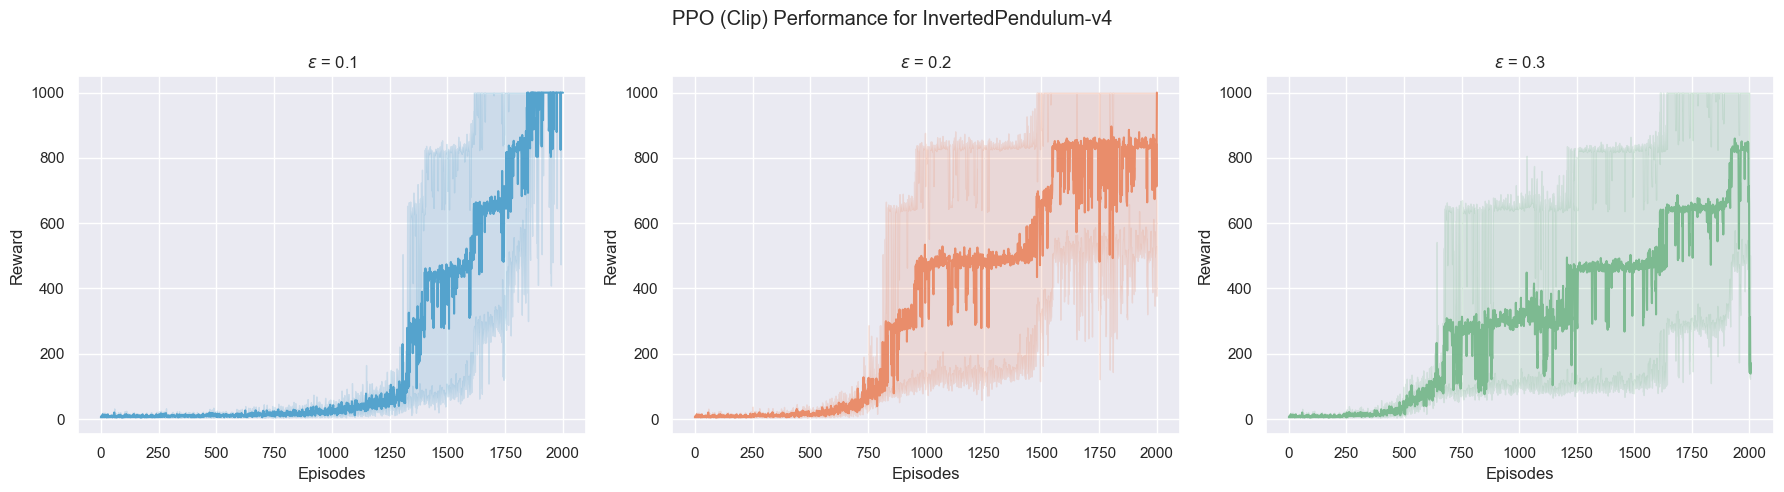

In [7]:
plt.figure(figsize=(18, 5))

for i, ((clip_eps, rewards), palette) in enumerate(zip(loaded_results.items(), ["flare", "crest", "icefire"])):
    plt.subplot(1, 3, i + 1)
    df = pd.DataFrame(rewards).melt()
    df.rename(columns={"variable": "Episodes", "value": "Reward"}, inplace=True)
    sns.set(style="darkgrid", palette=palette)
    ax = sns.lineplot(x="Episodes", y="Reward", data=df)
    ax.set(title=f"$\epsilon$ = {clip_eps}")

plt.suptitle("PPO (Clip) Performance for InvertedPendulum-v4")
plt.tight_layout()
plt.show()